In [40]:
# estatísticas básicas
import seaborn as sea
import scipy.stats as stats
import matplotlib.pyplot as plt
import pandas as pd


file_name = '../measurements.csv'
df = pd.read_csv(file_name, header = 0, delimiter=",", decimal=".")
df.head()

,Language,Program,PowerLimit,Package,Core,GPU,DRAM,Time,Temperature,Memory
0,C,fibo,1,37.386047,16.333740,,,35667,44.2,0
1,C,fibo,1,36.405090,15.609741,,,35847,44.0,0
2,C,fibo,1,39.516174,17.908630,,,37126,44.0,0
3,C,fibo,1,34.225159,14.475464,,,34067,43.5,0
4,C,fibo,1,34.903137,14.912903,,,34460,43.5,0


In [41]:
df = df.drop(['GPU', 'Core','DRAM'], axis=1)

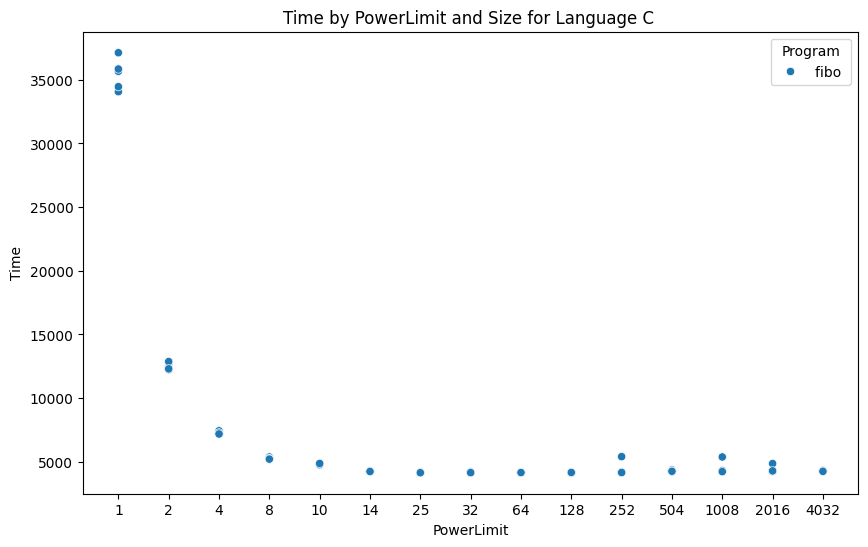

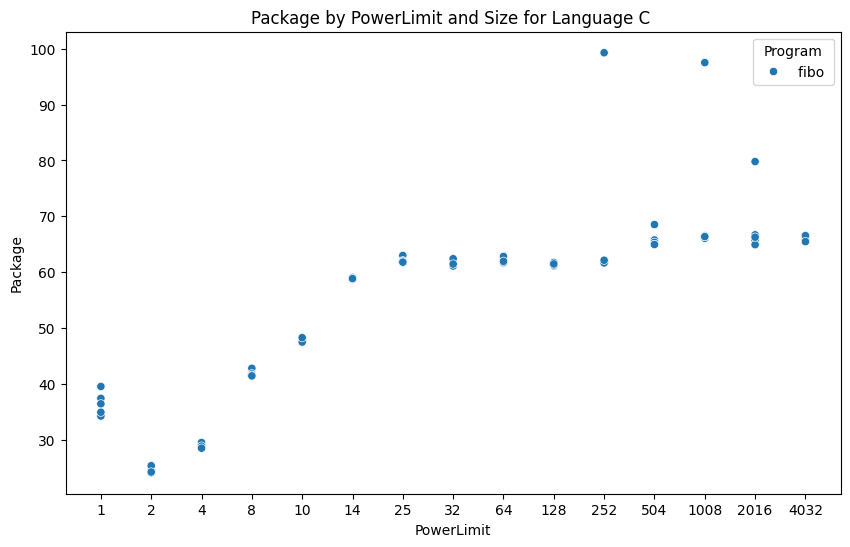

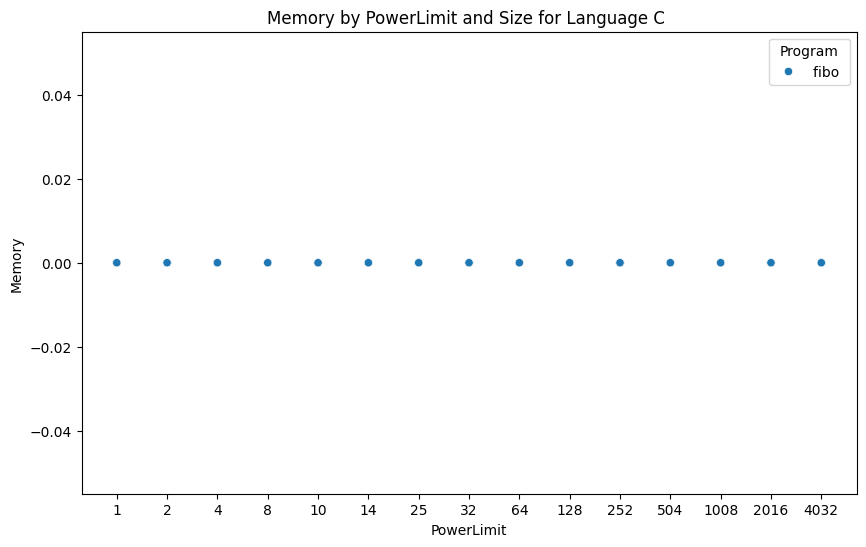

In [42]:


import matplotlib.pyplot as plt
import seaborn as sea

# Columns for comparison
columns = ["Time", "Package", "Memory"]
group_column = "PowerLimit"  # Specify the column to group by

# Iterate over the columns
for col in columns:
    languages = df['Language'].unique()
    for language in languages:
        plt.figure(figsize=(10, 6))
        
        data_subset = df[(df['Language'] == language)]
        data_subset['PowerLimit'] = data_subset['PowerLimit'].astype(str)
        
        ax = sea.scatterplot(data=data_subset, x=group_column, y=col, hue='Program')  # Add size='Size' parameter
        
        plt.xlabel(group_column)
        plt.ylabel(col)
        plt.title(f'{col} by {group_column} and Size for Language {language}')
        
        plt.legend(title='Program')
        plt.show()



In [ ]:
#Outliers treatment
#NOTE: This will remove 14*3*5*3*2 entries (14 languages, 3 sorting algorithms, 5 PowerLimit, 3 Sizes and 2 cases - best and worst executions)

# Agrupar o DataFrame por colunas "Language" e "Program"
grouped = df.groupby(['Language', 'Program', 'PowerLimit', 'Size'])

# Inicializar um DataFrame vazio para armazenar o resultado
df_removed_entries = pd.DataFrame()

# Iterar sobre cada grupo
for group_name, group_df in grouped:
    
    # Identificar o índice da melhor (menor tempo) e pior (maior tempo) entrada no grupo
    best_entry_index = group_df['Time'].idxmin()
    worst_entry_index = group_df['Time'].idxmax()
    if(best_entry_index==worst_entry_index):
        worst_entry_index+=1
    # Remover as linhas com base nos índices encontrados e adicionar ao DataFrame resultante 
    group_df = group_df.drop([best_entry_index, worst_entry_index])
    
    # Concatenar o DataFrame do grupo com o DataFrame resultante
    df_removed_entries = pd.concat([df_removed_entries, group_df])

df = df_removed_entries.copy()
# Imprimir o DataFrame resultante
print("Number of rows: ", len(df.index))
print(df)

In [ ]:
#Guardar medias para csv
grouped_table = df[(df['Size'] == 5000)&(df['PowerLimit'] == 1000) &(df['Program'] =='QuickSort ')]
grouped_table = grouped_table.drop('Size', axis=1)
grouped_table = grouped_table.drop('PowerLimit', axis=1)
grouped_table = grouped_table.drop('Program', axis=1)
grouped_table = grouped_table.groupby(['Language']).mean()
grouped_table.to_csv('filteredData.csv')

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sea

# Columns for comparison
columns = ["Time", "Package", "Memory"]
group_column = "PowerLimit"  # Specify the column to group by

# Iterate over the columns
for col in columns:
    languages = df['Language'].unique()
    for language in languages:
        plt.figure(figsize=(10, 6))
        
        data_subset = df[(df['Language'] == language) & (df['Size'] == 5000)]
        data_subset['PowerLimit'] = data_subset['PowerLimit'].astype(str)
        
        ax = sea.scatterplot(data=data_subset, x=group_column, y=col, hue='Program')  # Add size='Size' parameter
        
        plt.xlabel(group_column)
        plt.ylabel(col)
        plt.title(f'{col} by {group_column} and Size for Language {language}')
        
        plt.legend(title='Program')
        plt.show()

Conclusões a retirar-> O quickSort demonstra ser melhor em tempo e package. Em algumas excessões o selection sort é melhor mas vamos focar-nos na analise dos resultados do quickSort

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sea

size = 5000

for col in ["Time", "Memory", "Package"]:
    if col in ["Time", "Memory"]:
        plt.figure(figsize=(25, 16))  # Aumenta a altura do gráfico
    else:
        plt.figure(figsize=(25, 10))  # Tamanho padrão
    
    data_subset = df[(df['Size'] == size)&(df['Program'] == 'QuickSort ')]

    hue_labels = [val for val in data_subset['PowerLimit']]
    ax = sea.barplot(data=data_subset, x='Language', y=col, hue=hue_labels, errorbar=None)
    plt.xlabel('Language')
    plt.ylabel(col)
    plt.title(f'{col} by Language and PowerLimit (Size={size}) on QuickSort')
    plt.legend(title='PowerLimit')

    # Add the measured values on top of each bar
    for p in ax.patches:
        width = p.get_width()
        height = p.get_height()
        x, y = p.get_xy()
        
        ax.text(x + width / 2, y + height, format(height, '.2f'),
                ha='center', va='bottom', rotation='vertical')

    plt.show()


In [ ]:
import matplotlib.pyplot as plt
import seaborn as sea

# Criar um gráfico de barras agrupadas na orientação vertical para cada valor único da coluna "Size"
for col in ["Time", "Memory", "Package","Temperature"]:
    for size in df['Size'].unique():
        plt.figure(figsize=(30, 6))
        subset = df[(df['Size'] == size) &(df['PowerLimit'] == 1000)]
        ax = sea.barplot(data=subset, x='Language', y=col, hue='Program', errorbar=None)
        plt.xlabel('Language')
        plt.ylabel(col)
        plt.title(f'{col} by Language for Size {size}')
        plt.legend(title='Program')
        #ax.set_xticklabels(df['Language'].unique(), rotation=90)  # Definir os rótulos do eixo x como as línguas
    
        # Adicionar os valores medidos na vertical em cima de cada barra
        for p in ax.patches:
            height = p.get_height()
            ax.text(p.get_x() + p.get_width() / 2., height + 0.1, format(height, '.2f'),
                    ha='center', va='bottom', rotation='horizontal')
    
        plt.show()


In [ ]:
import matplotlib.pyplot as plt
import seaborn as sea


# Criar um gráfico de barras agrupadas na orientação vertical para cada valor único da coluna "Size"
for col in ["Time","Package"]:
    plt.figure(figsize=(10, 6))
    subset = df.loc[(df['PowerLimit'] == 5) & ((df['Language'] == "Python Compilled ") | (df['Language'] == "Python Interpreted ")), :]
    ax = sea.barplot(data=subset, x='Language', y=col, hue='Program', errorbar=None)
    plt.xlabel('Language')
    if col == "Package":
        plt.ylabel("Energy consumed (J)")
        plt.title("Energy by Language (PowerLimit = 5)")

    else:
        plt.ylabel("Time taken (ms)")
        plt.title("Time by Language (PowerLimit = 5)")

    plt.legend(title='Program', loc='upper left')
    #ax.set_xticklabels(df['Language'].unique(), rotation=90)  # Definir os rótulos do eixo x como as línguas

    # Adicionar os valores medidos na vertical em cima de cada barra
    for p in ax.patches:
        height = p.get_height()
        ax.text(p.get_x() + p.get_width() / 2., height + 0.1, format(height, '.2f'),
                ha='center', va='bottom', rotation='horizontal')

    plt.show()


In [ ]:
import matplotlib.pyplot as plt
import seaborn as sea

# Valor da coluna para comparação
col = "Cost"

plt.figure(figsize=(30, 6))
subset = df
ax = sea.barplot(data=subset, x='Language', y=col, hue='Program', errorbar=None)
plt.xlabel('Language')
plt.ylabel(col)
plt.title(f'{col} by Language and Program')
plt.legend(title='Program')
#ax.set_xticklabels(df['Language'].unique(), rotation=90)  # Definir os rótulos do eixo x como as línguas
# Adicionar os valores medidos na vertical em cima de cada barra
for p in ax.patches:
    height = p.get_height()
    ax.text(p.get_x() + p.get_width() / 2., height + 0.1, format(height, '.2f'),
            ha='center', va='bottom', rotation='horizontal')
plt.show()

In [ ]:
import seaborn as sns

new_df = df.drop(["Program", "Language"], axis=1)
corr_matrix = new_df.corr()

f, ax = plt.subplots(figsize=(12,10))
sns.heatmap(corr_matrix, vmin=-1, vmax=1, square=True, annot=True)

In [ ]:
sea.boxplot(data=df,hue='Program',x='Time',y='Language',medianprops={"color":"red"},
            flierprops={"marker": "."},)

In [ ]:
filtered_data = df[(df["PowerLimit"] == 5)]  
average_time = filtered_data.groupby("Program")["Package"].mean() 
average_time = average_time.sort_values(ascending=True) 

filtered_data2 = df[(df["PowerLimit"] == 1000)]
average_time2 = filtered_data2.groupby("Program")["Package"].mean() 
average_time2 = average_time2.sort_values(ascending=True) 

gain_loss = ((average_time - average_time2) / average_time2) * 100

gain_loss_formatted = gain_loss.map("{:.2f}%".format)

print(average_time)
print(average_time2)
print(gain_loss_formatted)


In [ ]:
feature = "Package"

filtered_data = df[(df["PowerLimit"] == 5) & (df["Program"] == "QuickSort ")]  
average_time = filtered_data.groupby("Language")[feature].mean() 
average_time = average_time.sort_values(ascending=True) 

filtered_data2 = df[(df["PowerLimit"] == 1000) & (df["Program"] == "QuickSort ")]  
average_time2 = filtered_data2.groupby("Language")[feature].mean() 
average_time2 = average_time2.sort_values(ascending=True) 

gain_loss = ((average_time - average_time2) / average_time2) * 100

gain_loss_formatted = gain_loss.map("{:.2f}%".format)

print(average_time)
print(average_time2)
print(gain_loss_formatted)
